# Extra examples

Yeah, I can't think of any names.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from itertools import cycle
from samplics.categorical import CrossTabulation
from typing import Literal, Optional

gss_saf = pd.read_csv("data/safiya_clean.csv")
gss_theo = pd.read_csv("data/theo_clean.csv")


def recode_age(age: int | Literal[np.nan, pd.NA]):
    """Destroy age by recoding it into a category.

    Parameters
    ----------
    age: int | Literal[np.nan, pd.NA]
        `age` feature from GSS.

    Returns
    -------
    str
        Lossy, categorized age as a string.
    """
    if age in range(18, 30):
        return "18-29"
    elif age in range(30, 40):
        return "30-39"
    elif age in range(40, 50):
        return "40-49"
    elif age in range(50, 60):
        return "50-59"
    elif age in range(60, 70):
        return "60-69"
    elif age > 69:
        return "70+"
    else:
        return pd.NA


def plot_aesthetics(fig: plt.Figure, ax: plt.Axes, title: Optional[str] = None) -> None:
    """Clean up plot aesthetics.

    Removes unimportant link from an Axes.

    Parameters
    ----------
    fig: plt.Figure
        Figure upon which Axes is plotted.
    ax: plt.Axes
        Plot.

    Returns
    -------
    None
    """
    # Title
    ax.set_title(title, fontsize=16, fontweight="bold")

    # Remove unimportant ink
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    # Remove legend title
    legend: plt.legend.Legend = ax.get_legend()
    legend.set_title(None)
    legend.draw_frame(False)

    # Remove spines and set the layout to tight
    sns.despine(fig, ax)
    fig.set_tight_layout(True)


def weighted_kde(
    data: pd.DataFrame,
    x: str,
    y: Optional[str] = None,
    hue: Optional[str] = None,
    weights: Optional[str] = None,
    palette: Optional[list[str] | dict[str, str]] = None,
    edgecolor: Optional[str | list[str]] = "black",
    figsize: Optional[tuple[int, int]] = (10, 8),
    title: Optional[str] = None,
) -> (plt.Figure, plt.Axes):
    """Meow."""
    fig: plt.Figure
    ax: plt.Axes

    fig, ax = plt.subplots(figsize=figsize)
    sns.kdeplot(
        data=data,
        x=x,
        hue=hue,
        weights=weights,
        cut=0,
        fill=True,
        palette=palette,
        ax=ax,
        edgecolor=edgecolor,
    )
    plot_aesthetics(fig, ax, title)

    return fig, ax


def crosstab_barplots(
    data: pd.DataFrame,
    x: str,
    y: str,
    hue: Optional[str] = None,
    weights: Optional[str] = None,
    stratum: Optional[str] = None,
    psu: Optional[str] = None,
    percents: Optional[bool] = True,
    palette: Optional[list[str] | dict[str, str]] = None,
    figsize: Optional[tuple[int, int]] = (10, 8),
    title: Optional[str] = None,
    sort: Optional[bool] = False
) -> (plt.Figure, plt.Axes):
    """Meow."""

    # Calculate cross tabulation
    tab_ct: CrossTabulation = CrossTabulation("proportion")
    tab_ct.tabulate(
        vars=data[[x, y]],
        samp_weight=data[weights] if weights else None,
        stratum=data[stratum] if stratum else None,
        psu=data[psu] if psu else None,
        remove_nan=True,
    )
    table: pd.DataFrame = tab_ct.to_dataframe()

    # Convert to percents if asked
    if percents:
        table["proportion"] = table["proportion"] * 100

    # Sort proportions if asked
    if sort:
        table = table.sort_values("proportion")

    # Plot bar
    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(x=x, y="proportion", hue=hue, data=table, palette=palette, ax=ax)
    plot_aesthetics(fig, ax, title)

    return fig, ax


gss_theo["age_cat"] = gss_theo["age"].map(recode_age)


## Plot examples (Theo)

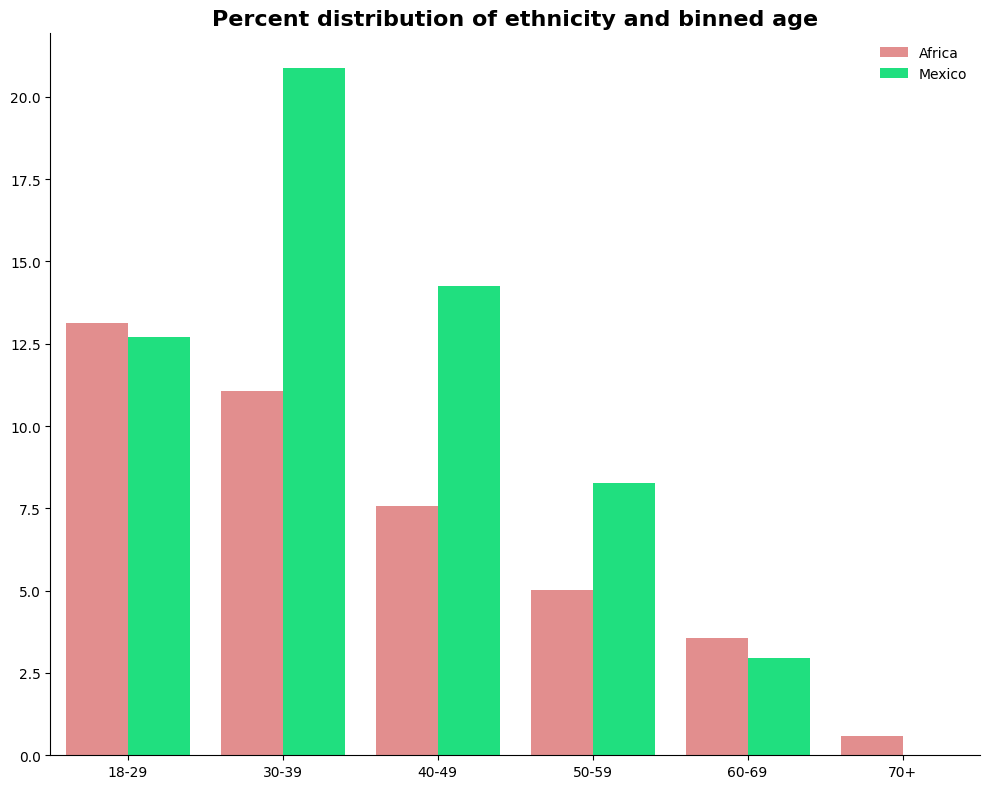

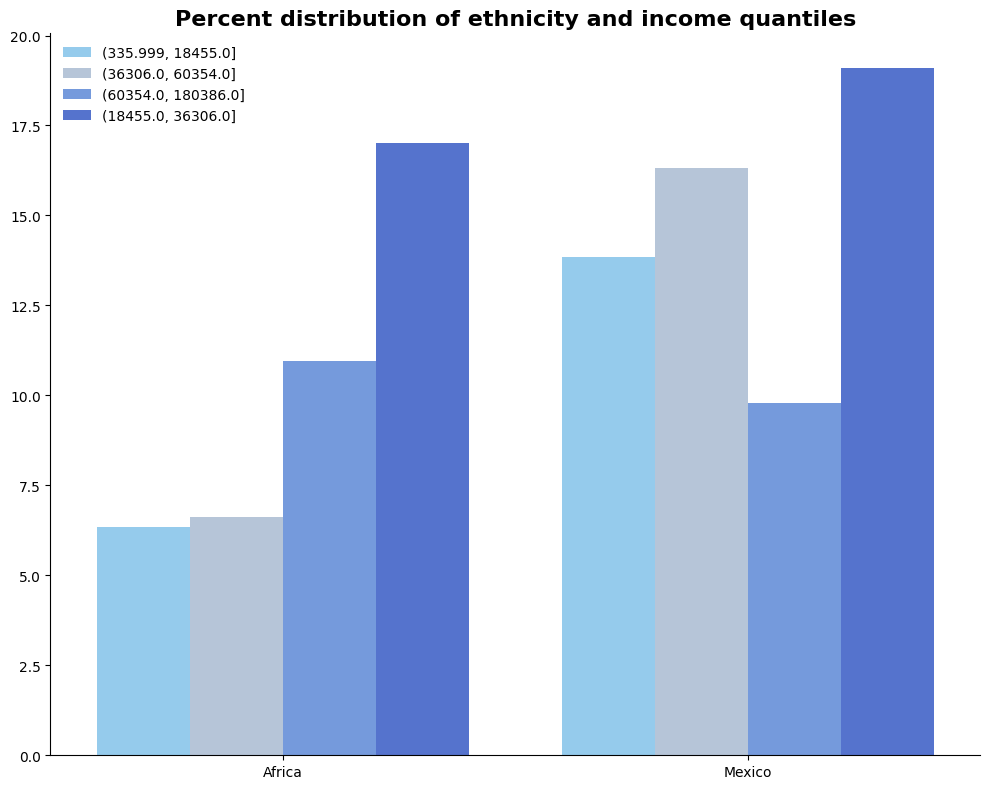

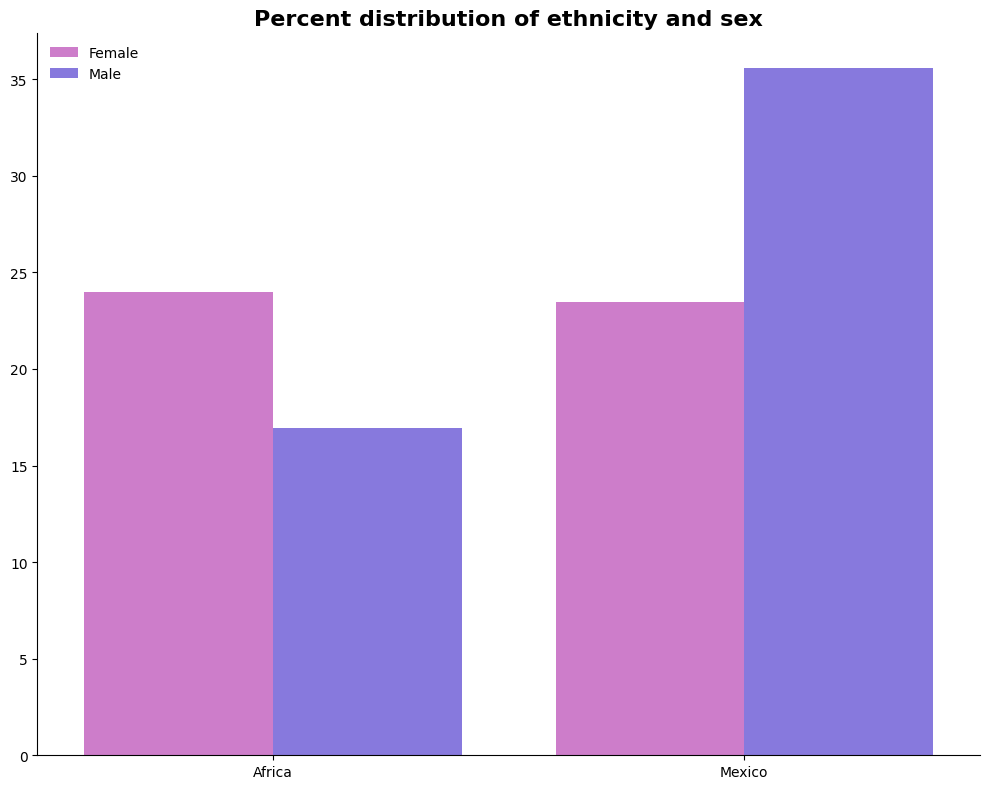

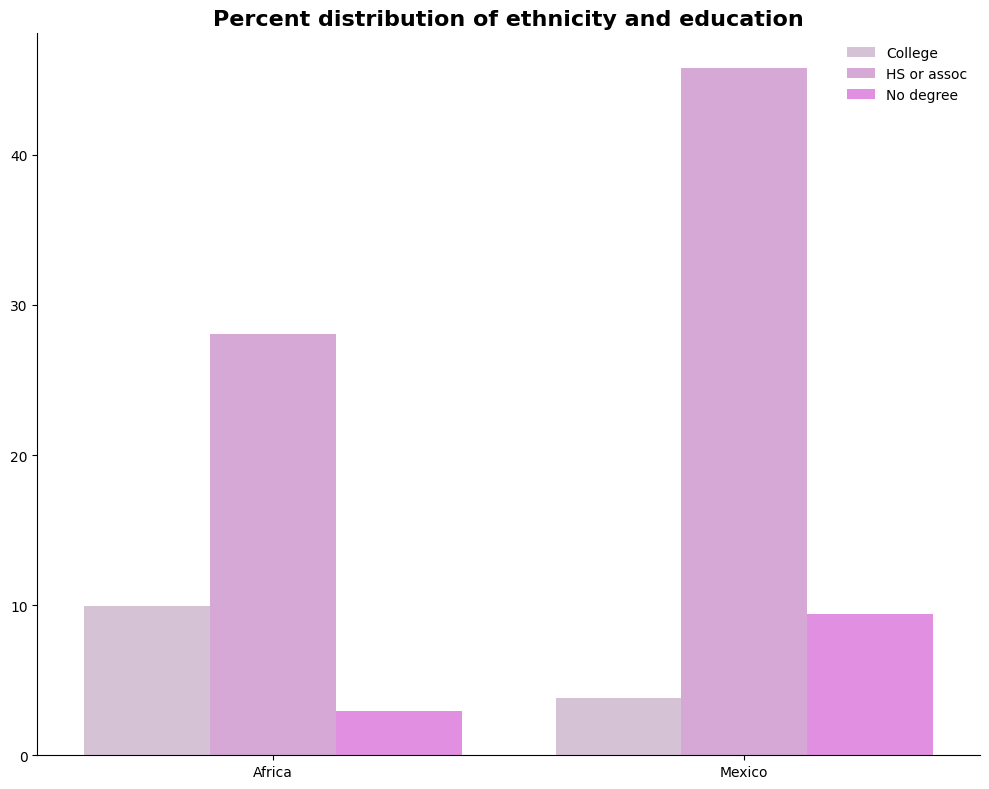

In [42]:
gss_theo = gss_theo.dropna()

ethn_age_fig, ethn_age_ax = crosstab_barplots(
    gss_theo,
    x="age_cat",
    y="ethnic",
    hue="ethnic",
    weights="wtsscomp",
    psu="vpsu",
    palette=["lightcoral", "springgreen"],
    title="Percent distribution of ethnicity and binned age",
)

ethn_inc_fig, ethn_inc_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="coninc_quantiles",
    hue="coninc_quantiles",
    weights="wtsscomp",
    psu="vpsu",
    palette=["lightskyblue", "lightsteelblue", "cornflowerblue", "royalblue"],
    title="Percent distribution of ethnicity and income quantiles",
    sort=True
)

ethn_sex_fig, ethn_sex_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="sex",
    hue="sex",
    weights="wtsscomp",
    psu="vpsu",
    palette=["orchid", "mediumslateblue"],
    title="Percent distribution of ethnicity and sex",
)

ethn_degree_fig, ethn_degree_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="degree",
    hue="degree",
    weights="wtsscomp",
    psu="vpsu",
    palette=["thistle", "plum", "violet"],
    title="Percent distribution of ethnicity and education",
)


## Plot examples (Safiya)

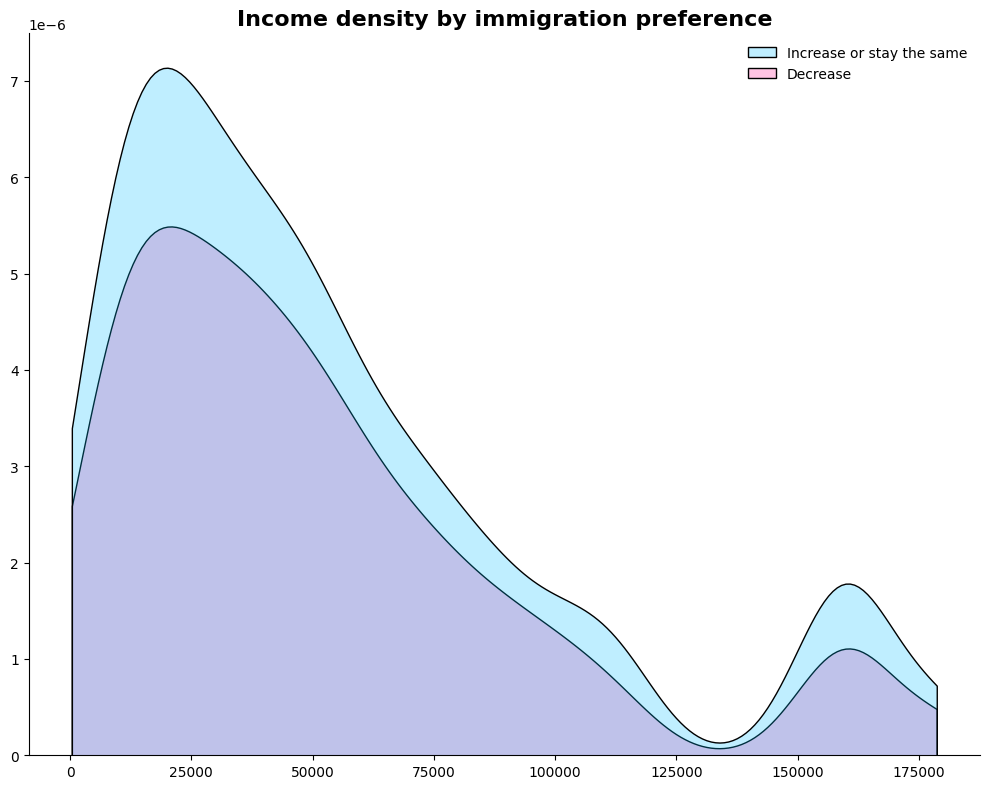

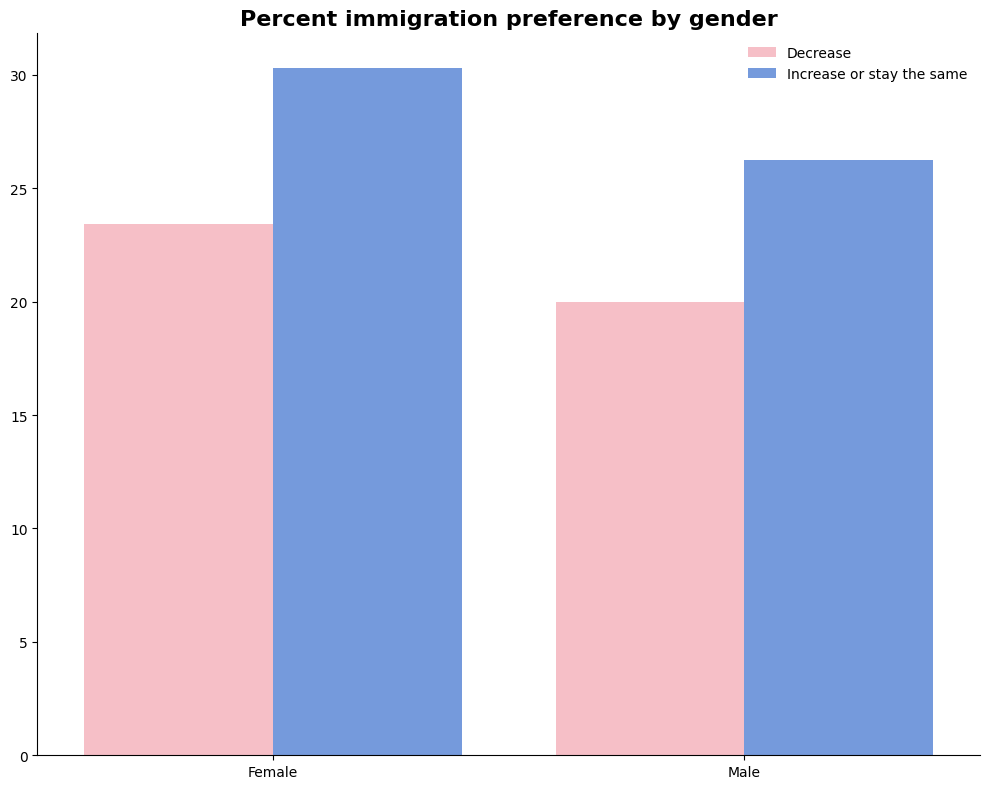

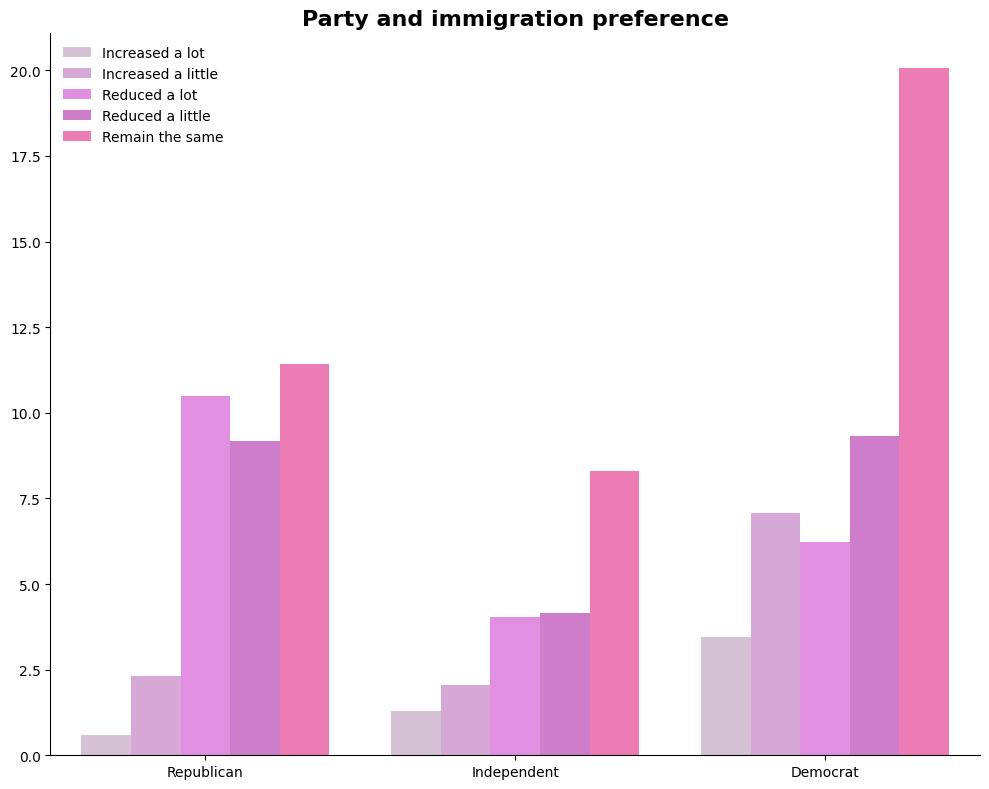

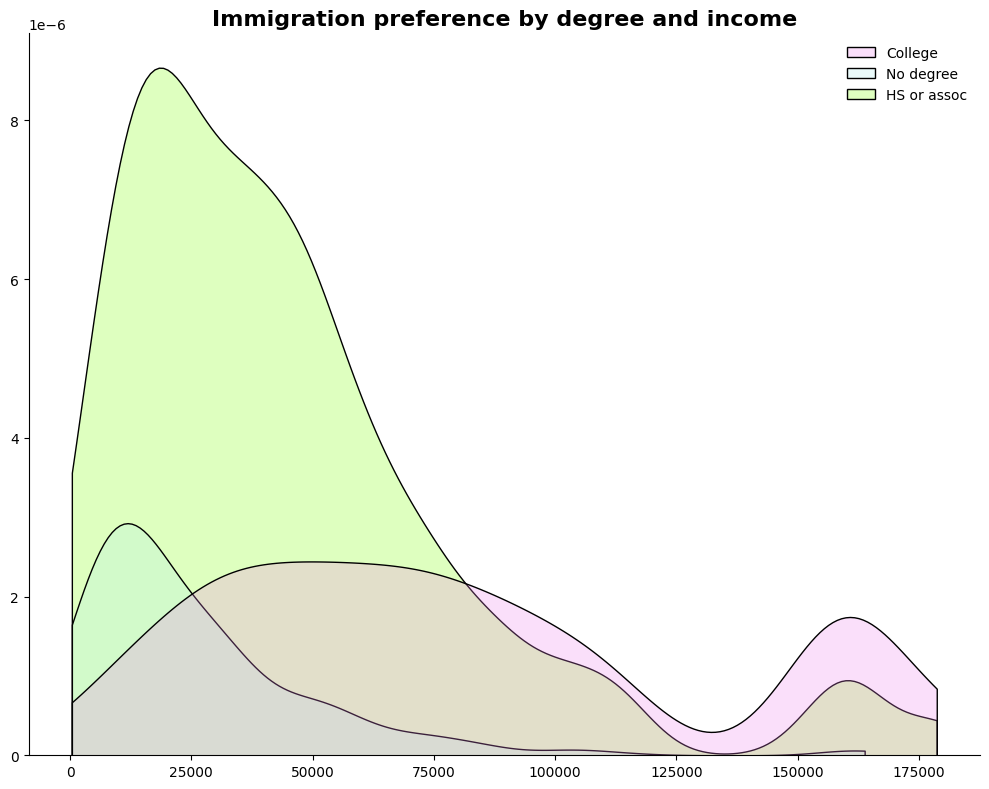

In [69]:
gss_saf = gss_saf.dropna()

coninc_imm_fig, coninc_imm_ax = weighted_kde(
    gss_saf,
    x="coninc",
    hue="decrease_imm",
    weights="wtsscomp",
    palette=["deepskyblue", "deeppink"],
    title="Income density by immigration preference",
)

imm_gend_fig, imm_gend_ax = crosstab_barplots(
    gss_saf,
    x="sex",
    y="decrease_imm",
    hue="decrease_imm",
    weights="wtsscomp",
    psu="vpsu",
    palette=["lightpink", "cornflowerblue"],
    title="Percent immigration preference by gender"
)

party_letin_fig, party_letin_ax = crosstab_barplots(
    gss_saf,
    x="partyid",
    y="letin1a",
    hue="letin1a",
    weights="wtsscomp",
    psu="vpsu",
    sort=True,
    palette=["thistle", "plum", "violet", "orchid", "hotpink"],
    title="Party and immigration preference"
)

ses_fig, ses_ax = weighted_kde(
    gss_saf,
    x="coninc",
    y="decrease_imm",
    hue="degree",
    weights="wtsscomp",
    palette=["violet", "paleturquoise", "chartreuse"],
    # edgecolor=["indigo", "darkturquoise", "forestgreen"],
    title="Immigration preference by degree and income"
)


## Chi square explanation

Let's take a look at some fake data.

In [65]:
party = np.repeat(["Democrat", "Republican"], [50, 50])
pastry = np.fromiter(cycle(["Cupcake", "Pie"]), np.dtype(('U', 7)), count=100)
great_debate = pd.DataFrame({"party": party, "pastry": pastry}, dtype="category")

great_debate


,party,pastry
0,Democrat,Cupcake
1,Democrat,Pie
2,Democrat,Cupcake
3,Democrat,Pie
4,Democrat,Cupcake
...,...,...
95,Republican,Pie
96,Republican,Cupcake
97,Republican,Pie
98,Republican,Cupcake


Traditional statistics is centered around inference. Researchers form a hypothesis which they test against a reasonable default. The reasonable default is called the **null hypothesis** or `H0`. `H0` is usually that there is no observable difference beyond random chance. This is also why traditional stats reports p-values. P-values are the probability that an observed difference is due to random chance.

For example, let's say we run a t-test between the mean ages of people who prefer strawberry ice cream and those who prefer chocolate.

`H0`: The difference in means between the ages of strawberry ice cream fans and chocolate ice cream fans is 0.

`H1`: Strawberry fans tend to be younger than choco fans.



## Logistic regression explanation